In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
import numpy as np
import arviz as az
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

# Data Analytics final project

## Problem Formulation 

### Problem Statement
This project addresses a classification problem aimed at predicting the likelihood of heart disease occurrence based on a variety of human health parameters. Accurately predicting heart disease is critical for early intervention and improving patient outcomes. The parameters used for prediction include:

- Chest pain type, </br>
- Resting blood pressure, </br>
- Cholesterol levels, </br>
- Fasting blood sugar, </br>
- And several others. </br>

### Purpose and Use Cases
The primary purpose of creating this model is to facilitate early detection of heart disease, enabling timely medical intervention. Potential use cases include:
- Assisting healthcare professionals in risk assessment during routine check-ups.
- Integrating with wearable health devices to provide real-time risk analysis.
- Supporting public health initiatives by identifying at-risk populations.

### Data Source
The dataset utilized for this project is sourced from a reputable Kaggle notebook on heart disease predictions, which can be accessed [here](https://www.kaggle.com/code/desalegngeb/heart-disease-predictions/notebook). The dataset includes a mix of continuous and discrete variables, each representing critical health metrics.

### Data Characteristics
The dataset comprises both continuous variables (e.g., resting blood pressure, cholesterol) and discrete variables (e.g., chest pain type, fasting blood sugar). Continuous variables will be appropriately scaled, and discrete variables will be encoded using suitable methods to ensure accurate modeling.

### DAG (Directed Acyclic Graph)
The following DAG represents the relationships between the variables considered in the analysis, highlighting potential causal pathways and dependencies:


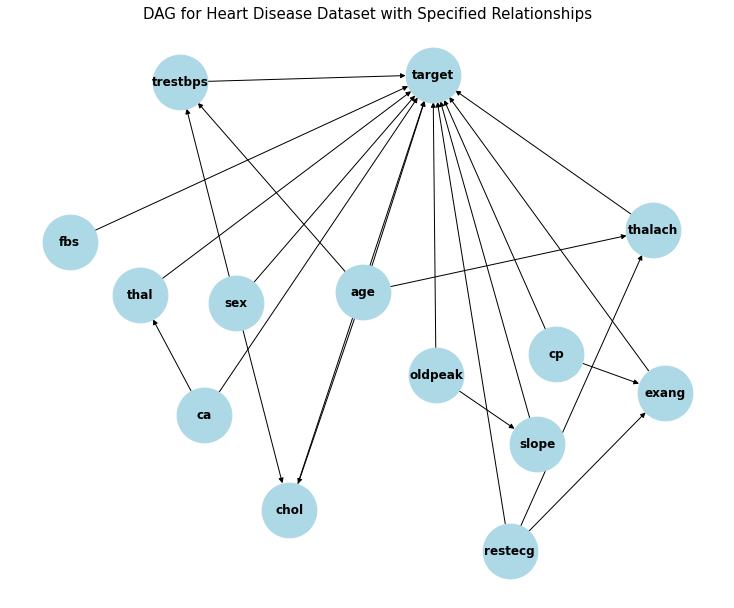

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

G_new = nx.DiGraph()

features = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 
    'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'
]

relationships = [
    ('age', 'thalach'),
    ('age', 'chol'),
    ('age', 'trestbps'),
    ('sex', 'chol'),
    ('sex', 'trestbps'),
    ('cp', 'exang'),
    ('restecg', 'thalach'),
    ('restecg', 'exang'),
    ('oldpeak', 'slope'),
    ('ca', 'thal'),
    ('age', 'target'),
    ('sex', 'target'),
    ('cp', 'target'),
    ('trestbps', 'target'),
    ('chol', 'target'),
    ('fbs', 'target'),
    ('restecg', 'target'),
    ('thalach', 'target'),
    ('exang', 'target'),
    ('oldpeak', 'target'),
    ('slope', 'target'),
    ('ca', 'target'),
    ('thal', 'target')
]

G_new.add_edges_from(relationships)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_new, seed=42)
nx.draw(G_new, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=12, font_weight="bold", arrows=True)
plt.title("DAG for Heart Disease Dataset with Specified Relationships", size=15)
plt.show()



### **Data Description**

- **age**: Age in years

- **sex**: Sex
  - 1 = male
  - 0 = female

- **cp**: Chest pain type
  - Value 0: typical angina
  - Value 1: atypical angina
  - Value 2: non-anginal pain
  - Value 3: asymptomatic

- **trestbps**: Resting blood pressure (in mm Hg on admission to the hospital)

- **chol**: Serum cholesterol in mg/dl

- **fbs**: (Fasting blood sugar > 120 mg/dl)
  - 1 = true
  - 0 = false

- **restecg**: Resting electrocardiographic results
  - Value 0: normal
  - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
  - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

- **thalach**: Maximum heart rate achieved

- **exang**: Exercise induced angina
  - 1 = yes
  - 0 = no

- **oldpeak**: ST depression induced by exercise relative to rest

- **slope**: The slope of the peak exercise ST segment
  - Value 0: upsloping
  - Value 1: flat
  - Value 2: downsloping

- **ca**: Number of major vessels (0-3) colored by fluoroscopy

- **thal**:
  - 0 = error (in the original dataset 0 maps to NaN's)
  - 1 = fixed defect
  - 2 = normal
  - 3 = reversible defect

- **target (label)**:
  - 0 = no disease
  - 1 = disease


### Confounding Factors
Potential confounding factors that may influence the analysis include age, sex, and existing health conditions. Identifying and addressing these confounders is essential to ensure the model's accuracy and reliability. The modeling process will account for these factors to mitigate their impact on the predictions.




## Data Preprocessing 


Considering that the dataset is already in a pre-processed form, the primary preprocessing task required is the careful selection of columns relevant to each model. This involves identifying the most pertinent features for accurate predictions, ensuring that the chosen columns contribute effectively to the model's performance. By focusing on the appropriate columns, we can optimize the data input for our classification models, enhancing their predictive capabilities and reliability.


In [20]:
import pandas as pd

In [21]:
data = pd.read_csv('heart.csv').dropna()
data_pd = data.copy()

In [22]:
model_1 = data[['age', 'trestbps', 'thalach']]
model_1.head(5)

,age,trestbps,thalach
0,63,145,150
1,37,130,187
2,41,130,172
3,56,120,178
4,57,120,163


In [23]:
model_2 = data[['age', 'trestbps', 'thalach', 'cp', 'chol', 'oldpeak']]
model_2.head(5)

,age,trestbps,thalach,cp,chol,oldpeak
0,63,145,150,3,233,2.3
1,37,130,187,2,250,3.5
2,41,130,172,1,204,1.4
3,56,120,178,1,236,0.8
4,57,120,163,0,354,0.6


## Model 

- Two distinct models are specified. Model 1 uses three features (age, resting blood pressure, maximum heart rate achieved), while Model 2 includes additional features (chest pain type, cholesterol, and old peak).

- The differences between the two models are clearly explained. Model 1 focuses on the basic health parameters (age, resting blood pressure, maximum heart rate), while Model 2 extends this by incorporating more detailed clinical measurements (chest pain type, cholesterol, and old peak).

- The inclusion of additional parameters in Model 2 is justified. These parameters are relevant to heart disease and could potentially enhance the model's predictive accuracy by capturing more comprehensive health information.

- Both models are sufficiently described. The parameters for each model are explicitly listed, and the corresponding data required for each model are specified.

In [24]:
print("Age mean:", model_1.iloc[:, 0].mean())
print("Resting blood pressure mean:", model_1.iloc[:, 1].mean())
print("Thalach mean:", model_1.iloc[:, 2].mean())
print("Age std:", model_1.iloc[:, 0].std())
print("Resting blood pressure std:", model_1.iloc[:, 1].std())
print("Thalach std:", model_1.iloc[:, 2].std())

Age mean: 54.366336633663366
Resting blood pressure mean: 131.62376237623764
Thalach mean: 149.64686468646866
Age std: 9.082100989837857
Resting blood pressure std: 17.5381428135171
Thalach std: 22.905161114914094


## Priors 



INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


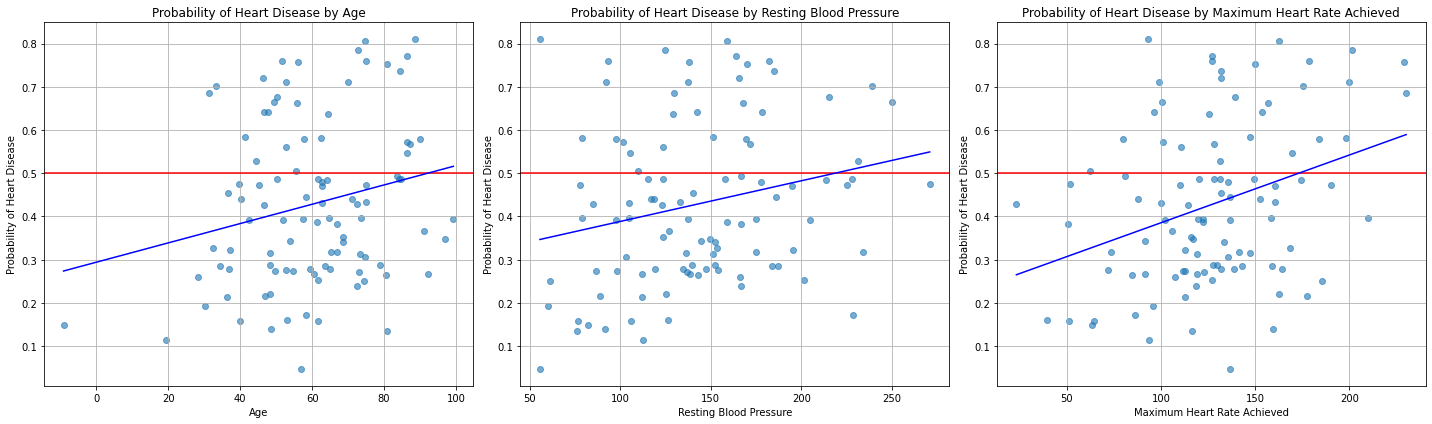

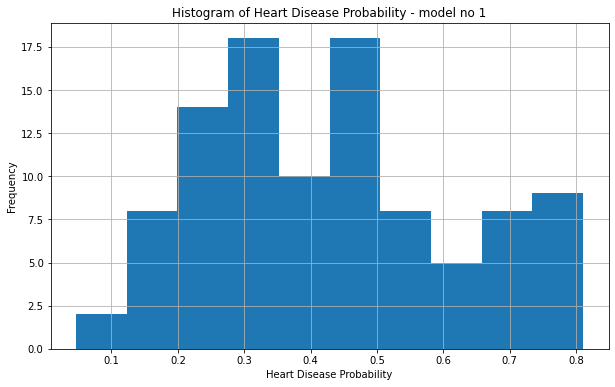

In [25]:
model1 = CmdStanModel(stan_file='prior_combined1.stan')
sim = model1.sample(iter_sampling=100,
                        iter_warmup=1000,
                        chains=1,
                        seed=242522,)
prior_model1 = sim.draws_pd()

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

x_age = prior_model1['age']
y_prob = prior_model1['combined_heart_disease_prob']
axs[0].scatter(x_age, y_prob, alpha=0.6)
axs[0].axhline(y=0.5, color='red', linestyle='-')

coeffs = np.polyfit(x_age, y_prob, 1)
x_range = np.linspace(x_age.min(), x_age.max(), 100)
axs[0].plot(x_range, np.polyval(coeffs, x_range), color='blue', linestyle='-')

axs[0].set_xlabel('Age')
axs[0].set_ylabel('Probability of Heart Disease')
axs[0].set_title('Probability of Heart Disease by Age')
axs[0].grid(True)

x_bps = prior_model1['bps']
axs[1].scatter(x_bps, y_prob, alpha=0.6)
axs[1].axhline(y=0.5, color='red', linestyle='-')

coeffs = np.polyfit(x_bps, y_prob, 1)
x_range = np.linspace(x_bps.min(), x_bps.max(), 100)
axs[1].plot(x_range, np.polyval(coeffs, x_range), color='blue', linestyle='-')

axs[1].set_xlabel('Resting Blood Pressure')
axs[1].set_ylabel('Probability of Heart Disease')
axs[1].set_title('Probability of Heart Disease by Resting Blood Pressure')
axs[1].grid(True)

x_thalach = prior_model1['thalach']
axs[2].scatter(x_thalach, y_prob, alpha=0.6)
axs[2].axhline(y=0.5, color='red', linestyle='-')

coeffs = np.polyfit(x_thalach, y_prob, 1)
x_range = np.linspace(x_thalach.min(), x_thalach.max(), 100)
axs[2].plot(x_range, np.polyval(coeffs, x_range), color='blue', linestyle='-')

axs[2].set_xlabel('Maximum Heart Rate Achieved')
axs[2].set_ylabel('Probability of Heart Disease')
axs[2].set_title('Probability of Heart Disease by Maximum Heart Rate Achieved')
axs[2].grid(True)

plt.tight_layout()

plt.show()

plt.figure(figsize=(10, 6))
plt.hist(prior_model1['combined_heart_disease_prob'])
plt.title('Histogram of Heart Disease Probability - model no 1')
plt.xlabel('Heart Disease Probability')
plt.ylabel('Frequency')
plt.grid()
plt.show()

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


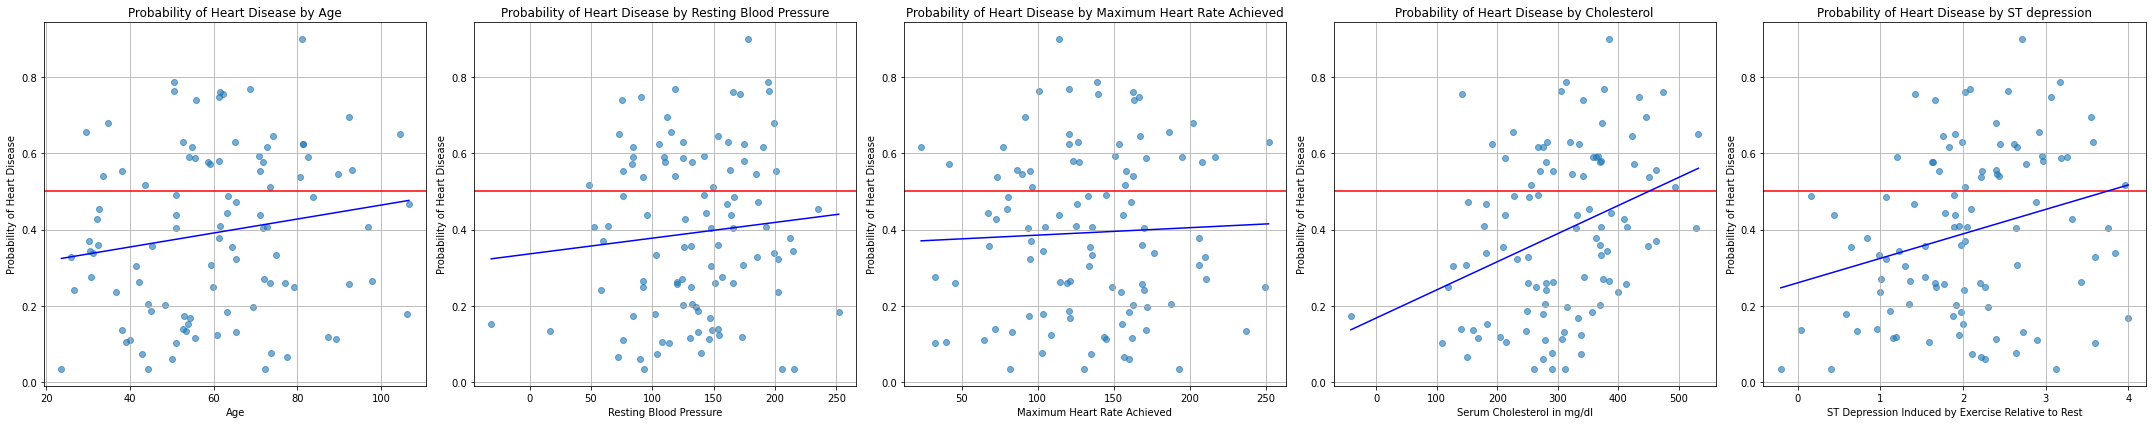

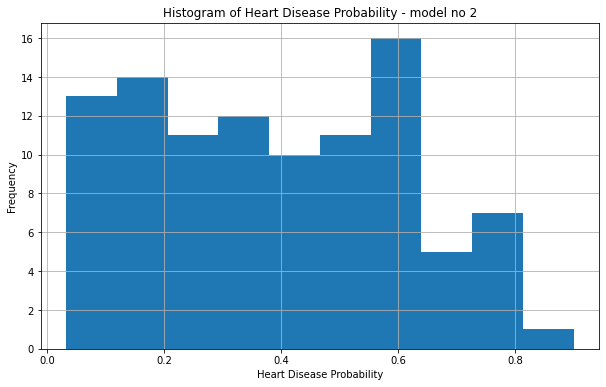

In [26]:
model2 = CmdStanModel(stan_file='prior_combined2.stan')
sim = model2.sample(iter_sampling=100,
                        iter_warmup=1000,
                        chains=1,
                        seed=242522,)
prior_model2 = sim.draws_pd()

fig, axs = plt.subplots(1, 5, figsize=(30, 6))

y_prob = prior_model2['combined_heart_disease_prob']

x_age = prior_model2['age']
axs[0].scatter(x_age, y_prob, alpha=0.6)
axs[0].axhline(y=0.5, color='red', linestyle='-')
coeffs = np.polyfit(x_age, y_prob, 1)
x_range = np.linspace(x_age.min(), x_age.max(), 100)
axs[0].plot(x_range, np.polyval(coeffs, x_range), color='blue', linestyle='-')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Probability of Heart Disease')
axs[0].set_title('Probability of Heart Disease by Age')
axs[0].grid(True)

x_bps = prior_model2['bps']
axs[1].scatter(x_bps, y_prob, alpha=0.6)
axs[1].axhline(y=0.5, color='red', linestyle='-')
coeffs = np.polyfit(x_bps, y_prob, 1)
x_range = np.linspace(x_bps.min(), x_bps.max(), 100)
axs[1].plot(x_range, np.polyval(coeffs, x_range), color='blue', linestyle='-')
axs[1].set_xlabel('Resting Blood Pressure')
axs[1].set_ylabel('Probability of Heart Disease')
axs[1].set_title('Probability of Heart Disease by Resting Blood Pressure')
axs[1].grid(True)

x_thalach = prior_model2['thalach']
axs[2].scatter(x_thalach, y_prob, alpha=0.6)
axs[2].axhline(y=0.5, color='red', linestyle='-')
coeffs = np.polyfit(x_thalach, y_prob, 1)
x_range = np.linspace(x_thalach.min(), x_thalach.max(), 100)
axs[2].plot(x_range, np.polyval(coeffs, x_range), color='blue', linestyle='-')
axs[2].set_xlabel('Maximum Heart Rate Achieved')
axs[2].set_ylabel('Probability of Heart Disease')
axs[2].set_title('Probability of Heart Disease by Maximum Heart Rate Achieved')
axs[2].grid(True)

x_chol = prior_model2['chol']
axs[3].scatter(x_chol, y_prob, alpha=0.6)
axs[3].axhline(y=0.5, color='red', linestyle='-')
coeffs = np.polyfit(x_chol, y_prob, 1)
x_range = np.linspace(x_chol.min(), x_chol.max(), 100)
axs[3].plot(x_range, np.polyval(coeffs, x_range), color='blue', linestyle='-')
axs[3].set_xlabel('Serum Cholesterol in mg/dl')
axs[3].set_ylabel('Probability of Heart Disease')
axs[3].set_title('Probability of Heart Disease by Cholesterol')
axs[3].grid(True)

x_old_peak = prior_model2['old_peak']
axs[4].scatter(x_old_peak, y_prob, alpha=0.6)
axs[4].axhline(y=0.5, color='red', linestyle='-')
coeffs = np.polyfit(x_old_peak, y_prob, 1)
x_range = np.linspace(x_old_peak.min(), x_old_peak.max(), 100)
axs[4].plot(x_range, np.polyval(coeffs, x_range), color='blue', linestyle='-')
axs[4].set_xlabel('ST Depression Induced by Exercise Relative to Rest')
axs[4].set_ylabel('Probability of Heart Disease')
axs[4].set_title('Probability of Heart Disease by ST depression')
axs[4].grid(True)

plt.tight_layout()

plt.show()

plt.figure(figsize=(10, 6))
plt.hist(prior_model2['combined_heart_disease_prob'])
plt.title('Histogram of Heart Disease Probability - model no 2')
plt.xlabel('Heart Disease Probability')
plt.ylabel('Frequency')
plt.grid()
plt.show()

## Posterior Analysis (Model 1) 



INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:03 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


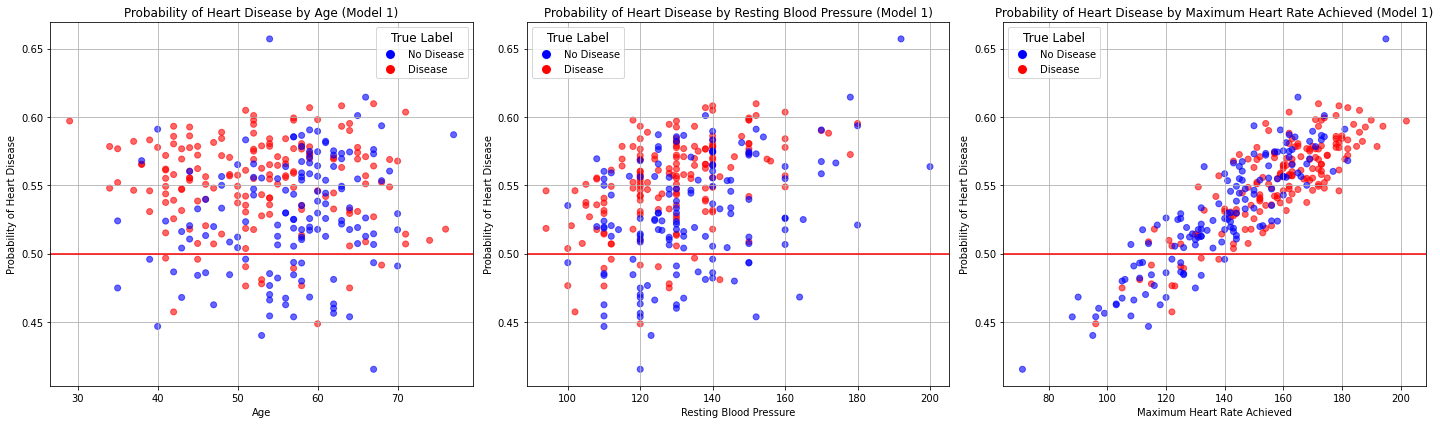

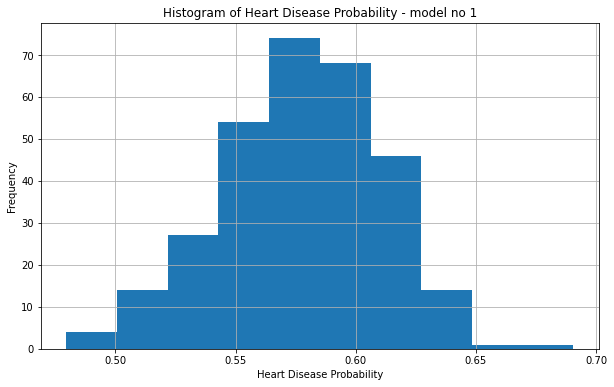

In [27]:
data = pd.read_csv('heart.csv').dropna()
data1 = data[['age', 'trestbps', 'thalach', 'target']]
data1

posterior1_model = CmdStanModel(stan_file='posterior1.stan')
data_model1 = {'N': len(data1), 'age': data1.iloc[:, 0], 'bps': data1.iloc[:, 1], 'thalach': data1.iloc[:, 2], 'y': data1.iloc[:, 3]}
sim = posterior1_model.sample(data=data_model1,
                        iter_sampling=1000,
                        iter_warmup=1000,
                        chains=1,
                        fixed_param=False,
                        seed=24252)
posterior1 = sim.draws_pd()

true_labels = data['target'].values

predictions1 = sim.stan_variable('combined_heart_disease_prob').mean(axis=0)

data_model1['y'] = predictions1

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

x_age = data_model1['age']
y_prob = data_model1['y']
scatter = axs[0].scatter(x_age, y_prob, c=true_labels, cmap='bwr', alpha=0.6)
axs[0].axhline(y=0.5, color='red', linestyle='-')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Probability of Heart Disease')
axs[0].set_title('Probability of Heart Disease by Age (Model 1)')
axs[0].grid(True)
axs[0].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='No Disease'),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Disease')],
             title='True Label', title_fontsize='large')

x_bps = data_model1['bps']
scatter = axs[1].scatter(x_bps, y_prob, c=true_labels, cmap='bwr', alpha=0.6)
axs[1].axhline(y=0.5, color='red', linestyle='-')
axs[1].set_xlabel('Resting Blood Pressure')
axs[1].set_ylabel('Probability of Heart Disease')
axs[1].set_title('Probability of Heart Disease by Resting Blood Pressure (Model 1)')
axs[1].grid(True)
axs[1].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='No Disease'),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Disease')],
             title='True Label', title_fontsize='large')

x_thalach = data_model1['thalach']
scatter = axs[2].scatter(x_thalach, y_prob, c=true_labels, cmap='bwr', alpha=0.6)
axs[2].axhline(y=0.5, color='red', linestyle='-')
axs[2].set_xlabel('Maximum Heart Rate Achieved')
axs[2].set_ylabel('Probability of Heart Disease')
axs[2].set_title('Probability of Heart Disease by Maximum Heart Rate Achieved (Model 1)')
axs[2].grid(True)
axs[2].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='No Disease'),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Disease')],
             title='True Label', title_fontsize='large')

plt.tight_layout()
plt.show()

histogram_data = []
for i in range(len(data1)):
    histogram_data.append(posterior1[f"combined_heart_disease_prob[{i + 1}]"][0])
plt.figure(figsize=(10, 6))
plt.hist(histogram_data)
plt.title('Histogram of Heart Disease Probability - model no 1')
plt.xlabel('Heart Disease Probability')
plt.ylabel('Frequency')
plt.grid()
plt.show()

2nd attempt for posterior model 1

INFO:cmdstanpy:found newer exe file, not recompiling


INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:05 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


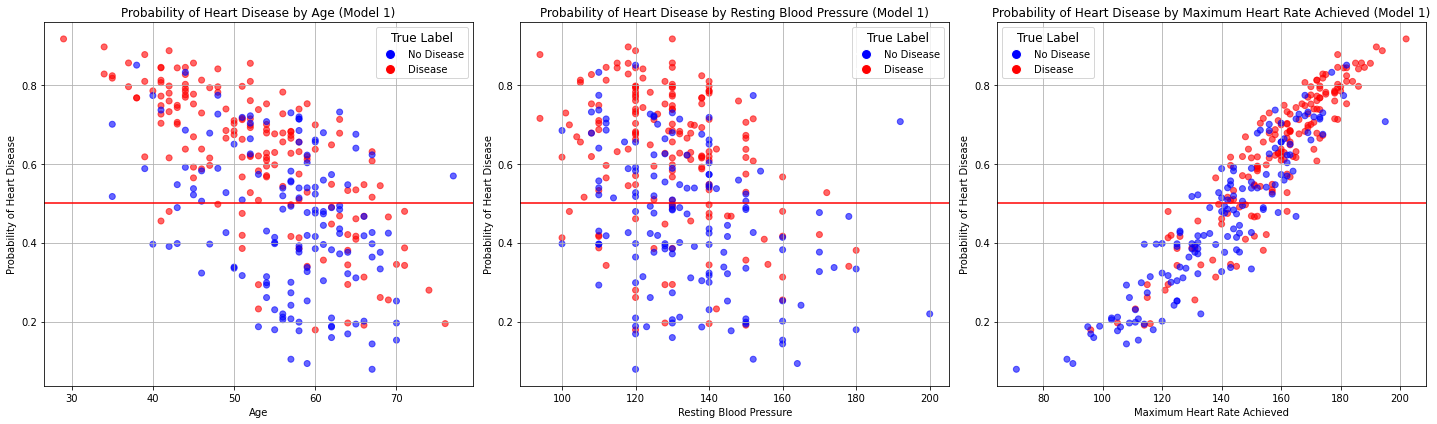

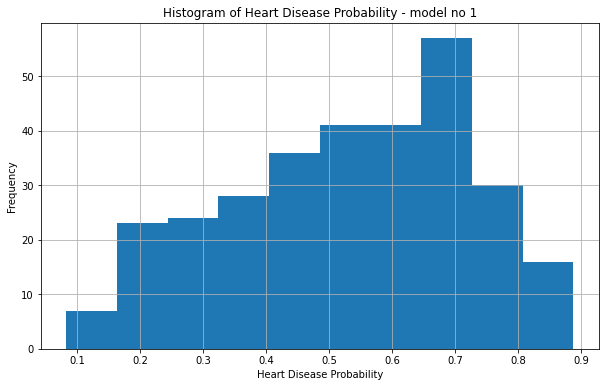

In [28]:
posterior1_model = CmdStanModel(stan_file='posterior1_2nd_try.stan')
data_model1 = {'N': len(data1), 'age': data1.iloc[:, 0], 'bps': data1.iloc[:, 1], 'thalach': data1.iloc[:, 2], 'y': data1.iloc[:, 3]}
sim1 = posterior1_model.sample(data=data_model1,
                        iter_sampling=1000,
                        iter_warmup=1000,
                        chains=1,
                        fixed_param=False,
                        seed=24252)
posterior1 = sim1.draws_pd()

true_labels = data['target'].values

predictions1 = sim1.stan_variable('combined_heart_disease_prob').mean(axis=0)

data_model1['y'] = predictions1

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Age vs Probability of Heart Disease
x_age = data_model1['age']
y_prob = data_model1['y']
scatter = axs[0].scatter(x_age, y_prob, c=true_labels, cmap='bwr', alpha=0.6)
axs[0].axhline(y=0.5, color='red', linestyle='-')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Probability of Heart Disease')
axs[0].set_title('Probability of Heart Disease by Age (Model 1)')
axs[0].grid(True)
axs[0].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='No Disease'),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Disease')],
             title='True Label', title_fontsize='large')

# Resting Blood Pressure vs Probability of Heart Disease
x_bps = data_model1['bps']
scatter = axs[1].scatter(x_bps, y_prob, c=true_labels, cmap='bwr', alpha=0.6)
axs[1].axhline(y=0.5, color='red', linestyle='-')
axs[1].set_xlabel('Resting Blood Pressure')
axs[1].set_ylabel('Probability of Heart Disease')
axs[1].set_title('Probability of Heart Disease by Resting Blood Pressure (Model 1)')
axs[1].grid(True)
axs[1].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='No Disease'),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Disease')],
             title='True Label', title_fontsize='large')

# Maximum Heart Rate Achieved vs Probability of Heart Disease
x_thalach = data_model1['thalach']
scatter = axs[2].scatter(x_thalach, y_prob, c=true_labels, cmap='bwr', alpha=0.6)
axs[2].axhline(y=0.5, color='red', linestyle='-')
axs[2].set_xlabel('Maximum Heart Rate Achieved')
axs[2].set_ylabel('Probability of Heart Disease')
axs[2].set_title('Probability of Heart Disease by Maximum Heart Rate Achieved (Model 1)')
axs[2].grid(True)
axs[2].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='No Disease'),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Disease')],
             title='True Label', title_fontsize='large')

plt.tight_layout()
plt.show()

histogram_data = []
for i in range(len(data1)):
    histogram_data.append(posterior1[f"combined_heart_disease_prob[{i + 1}]"][0])
plt.figure(figsize=(10, 6))
plt.hist(histogram_data)
plt.title('Histogram of Heart Disease Probability - model no 1')
plt.xlabel('Heart Disease Probability')
plt.ylabel('Frequency')
plt.grid()
plt.show()

## Posterior Analysis (Model 2)



INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:09 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 01:05 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


/tmp/ipykernel_4738/279806918.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model2['y'] = predictions2


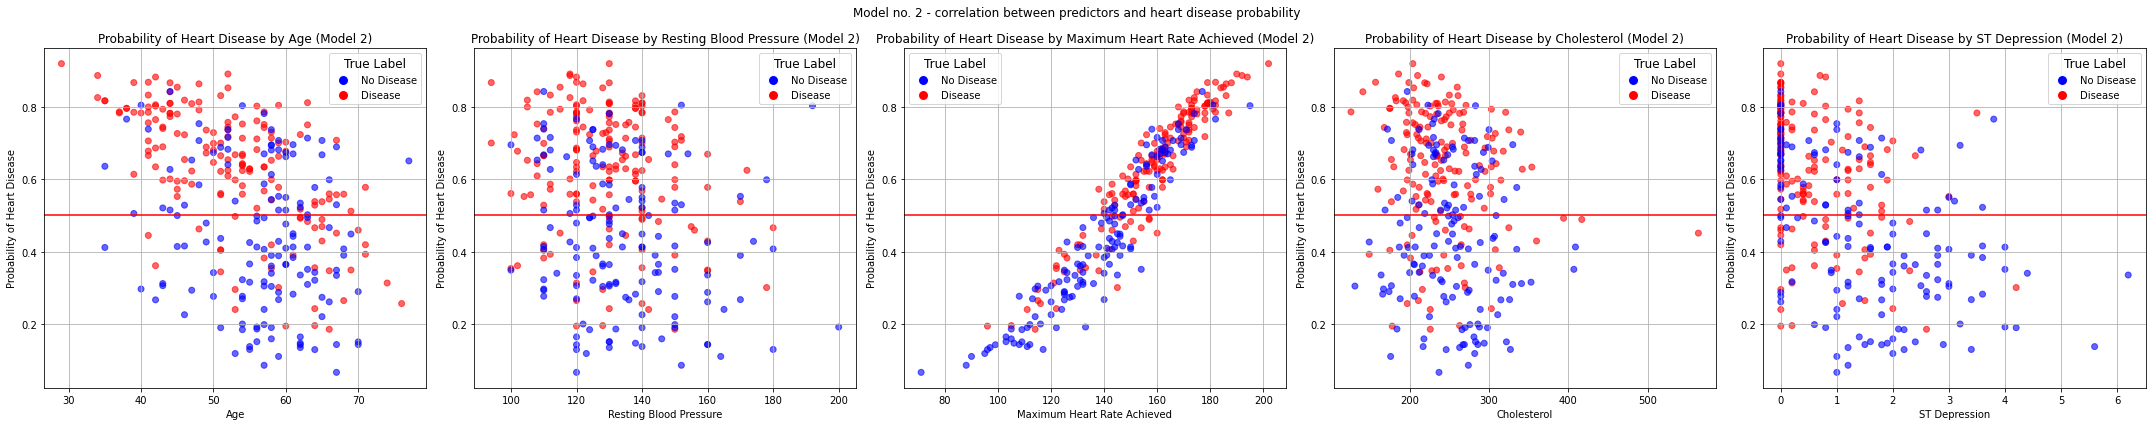

/tmp/ipykernel_4738/279806918.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model2['y'] = predictions2_q


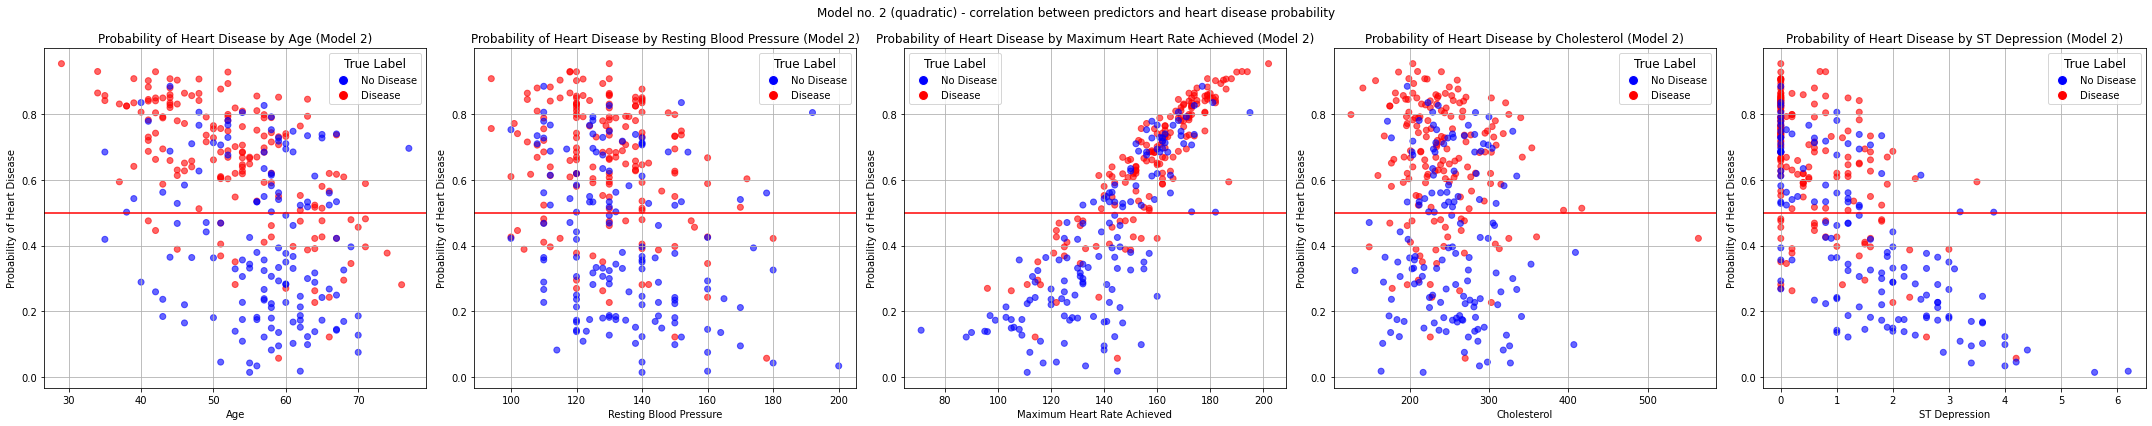

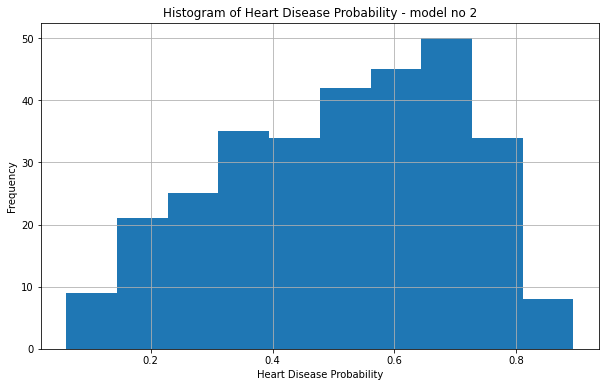

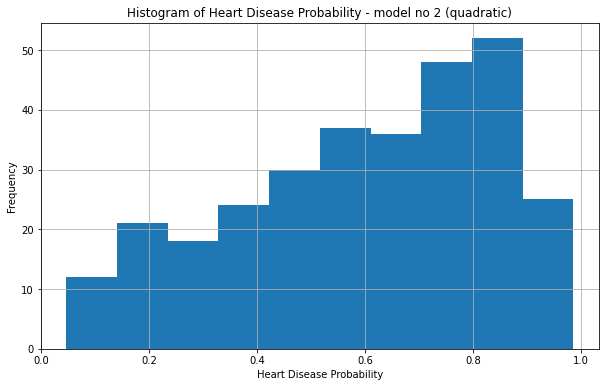

In [29]:
data = pd.read_csv('heart.csv').dropna()
data_model2 = data[['age', 'trestbps', 'thalach', 'chol', 'oldpeak']]
data_model2_dict = {
    'N': len(data_model2),
    'age': data_model2['age'].values,
    'trestbps': data_model2['trestbps'].values,
    'thalach': data_model2['thalach'].values,
    'chol': data_model2['chol'].values,
    'oldpeak': data_model2['oldpeak'].values,
    'y': data['target'].values
}

posterior2_model = CmdStanModel(stan_file='posterior2.stan')
sim2 = posterior2_model.sample(data=data_model2_dict,
                        iter_sampling=1000,
                        iter_warmup=1000,
                        chains=1,
                        fixed_param=False,
                        seed=24252)
posterior2 = sim2.draws_pd()

data = pd.read_csv('heart.csv').dropna()
data_model2 = data[['age', 'trestbps', 'thalach', 'chol', 'oldpeak']]
data_model2_dict = {
    'N': len(data_model2),
    'age': data_model2['age'].values,
    'trestbps': data_model2['trestbps'].values,
    'thalach': data_model2['thalach'].values,
    'chol': data_model2['chol'].values,
    'oldpeak': data_model2['oldpeak'].values,
    'y': data['target'].values
}

posterior2_model_q = CmdStanModel(stan_file='posterior2_quadratic.stan')
sim2_q = posterior2_model_q.sample(data=data_model2_dict,
                        iter_sampling=1000,
                        iter_warmup=1000,
                        chains=1,
                        fixed_param=False,
                        seed=24252)
posterior2_q = sim2_q.draws_pd()

true_labels = data['target'].values

predictions2 = sim2.stan_variable('combined_heart_disease_prob').mean(axis=0)

data_model2['y'] = predictions2

fig, axs = plt.subplots(1, 5, figsize=(30, 6))
fig.suptitle('Model no. 2 - correlation between predictors and heart disease probability')

# Age vs Probability of Heart Disease
x_age = data_model2['age']
y_prob = data_model2['y']
scatter = axs[0].scatter(x_age, y_prob, c=true_labels, cmap='bwr', alpha=0.6)
axs[0].axhline(y=0.5, color='red', linestyle='-')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Probability of Heart Disease')
axs[0].set_title('Probability of Heart Disease by Age (Model 2)')
axs[0].grid(True)
axs[0].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='No Disease'),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Disease')],
             title='True Label', title_fontsize='large')

# Resting Blood Pressure vs Probability of Heart Disease
x_bps = data_model2['trestbps']
scatter = axs[1].scatter(x_bps, y_prob, c=true_labels, cmap='bwr', alpha=0.6)
axs[1].axhline(y=0.5, color='red', linestyle='-')
axs[1].set_xlabel('Resting Blood Pressure')
axs[1].set_ylabel('Probability of Heart Disease')
axs[1].set_title('Probability of Heart Disease by Resting Blood Pressure (Model 2)')
axs[1].grid(True)
axs[1].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='No Disease'),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Disease')],
             title='True Label', title_fontsize='large')

# Maximum Heart Rate Achieved vs Probability of Heart Disease
x_thalach = data_model2['thalach']
scatter = axs[2].scatter(x_thalach, y_prob, c=true_labels, cmap='bwr', alpha=0.6)
axs[2].axhline(y=0.5, color='red', linestyle='-')
axs[2].set_xlabel('Maximum Heart Rate Achieved')
axs[2].set_ylabel('Probability of Heart Disease')
axs[2].set_title('Probability of Heart Disease by Maximum Heart Rate Achieved (Model 2)')
axs[2].grid(True)
axs[2].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='No Disease'),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Disease')],
             title='True Label', title_fontsize='large')

# Cholesterol vs Probability of Heart Disease
x_chol = data_model2['chol']
scatter = axs[3].scatter(x_chol, y_prob, c=true_labels, cmap='bwr', alpha=0.6)
axs[3].axhline(y=0.5, color='red', linestyle='-')
axs[3].set_xlabel('Cholesterol')
axs[3].set_ylabel('Probability of Heart Disease')
axs[3].set_title('Probability of Heart Disease by Cholesterol (Model 2)')
axs[3].grid(True)
axs[3].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='No Disease'),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Disease')],
             title='True Label', title_fontsize='large')

# ST Depression vs Probability of Heart Disease
x_oldpeak = data_model2['oldpeak']
scatter = axs[4].scatter(x_oldpeak, y_prob, c=true_labels, cmap='bwr', alpha=0.6)
axs[4].axhline(y=0.5, color='red', linestyle='-')
axs[4].set_xlabel('ST Depression')
axs[4].set_ylabel('Probability of Heart Disease')
axs[4].set_title('Probability of Heart Disease by ST Depression (Model 2)')
axs[4].grid(True)
axs[4].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='No Disease'),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Disease')],
             title='True Label', title_fontsize='large')

plt.tight_layout()
plt.show()

true_labels = data['target'].values

predictions2_q = sim2_q.stan_variable('combined_heart_disease_prob').mean(axis=0)

data_model2['y'] = predictions2_q

fig, axs = plt.subplots(1, 5, figsize=(30, 6))
fig.suptitle('Model no. 2 (quadratic) - correlation between predictors and heart disease probability')
# Age vs Probability of Heart Disease
x_age = data_model2['age']
y_prob = data_model2['y']
scatter = axs[0].scatter(x_age, y_prob, c=true_labels, cmap='bwr', alpha=0.6)
axs[0].axhline(y=0.5, color='red', linestyle='-')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Probability of Heart Disease')
axs[0].set_title('Probability of Heart Disease by Age (Model 2)')
axs[0].grid(True)
axs[0].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='No Disease'),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Disease')],
             title='True Label', title_fontsize='large')

# Resting Blood Pressure vs Probability of Heart Disease
x_bps = data_model2['trestbps']
scatter = axs[1].scatter(x_bps, y_prob, c=true_labels, cmap='bwr', alpha=0.6)
axs[1].axhline(y=0.5, color='red', linestyle='-')
axs[1].set_xlabel('Resting Blood Pressure')
axs[1].set_ylabel('Probability of Heart Disease')
axs[1].set_title('Probability of Heart Disease by Resting Blood Pressure (Model 2)')
axs[1].grid(True)
axs[1].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='No Disease'),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Disease')],
             title='True Label', title_fontsize='large')

# Maximum Heart Rate Achieved vs Probability of Heart Disease
x_thalach = data_model2['thalach']
scatter = axs[2].scatter(x_thalach, y_prob, c=true_labels, cmap='bwr', alpha=0.6)
axs[2].axhline(y=0.5, color='red', linestyle='-')
axs[2].set_xlabel('Maximum Heart Rate Achieved')
axs[2].set_ylabel('Probability of Heart Disease')
axs[2].set_title('Probability of Heart Disease by Maximum Heart Rate Achieved (Model 2)')
axs[2].grid(True)
axs[2].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='No Disease'),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Disease')],
             title='True Label', title_fontsize='large')

# Cholesterol vs Probability of Heart Disease
x_chol = data_model2['chol']
scatter = axs[3].scatter(x_chol, y_prob, c=true_labels, cmap='bwr', alpha=0.6)
axs[3].axhline(y=0.5, color='red', linestyle='-')
axs[3].set_xlabel('Cholesterol')
axs[3].set_ylabel('Probability of Heart Disease')
axs[3].set_title('Probability of Heart Disease by Cholesterol (Model 2)')
axs[3].grid(True)
axs[3].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='No Disease'),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Disease')],
             title='True Label', title_fontsize='large')

# ST Depression vs Probability of Heart Disease
x_oldpeak = data_model2['oldpeak']
scatter = axs[4].scatter(x_oldpeak, y_prob, c=true_labels, cmap='bwr', alpha=0.6)
axs[4].axhline(y=0.5, color='red', linestyle='-')
axs[4].set_xlabel('ST Depression')
axs[4].set_ylabel('Probability of Heart Disease')
axs[4].set_title('Probability of Heart Disease by ST Depression (Model 2)')
axs[4].grid(True)
axs[4].legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='No Disease'),
                       plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Disease')],
             title='True Label', title_fontsize='large')

plt.tight_layout()
plt.show()

histogram_data = []
for i in range(len(model_2)):
    histogram_data.append(posterior2[f"combined_heart_disease_prob[{i + 1}]"][0])
plt.figure(figsize=(10, 6))
plt.hist(histogram_data)
plt.title('Histogram of Heart Disease Probability - model no 2')
plt.xlabel('Heart Disease Probability')
plt.ylabel('Frequency')
plt.grid()
plt.show()

histogram_data = []
for i in range(len(model_2)):
    histogram_data.append(posterior2_q[f"combined_heart_disease_prob[{i + 1}]"][0])
plt.figure(figsize=(10, 6))
plt.hist(histogram_data)
plt.title('Histogram of Heart Disease Probability - model no 2 (quadratic)')
plt.xlabel('Heart Disease Probability')
plt.ylabel('Frequency')
plt.grid()
plt.show()

## Model Comparison



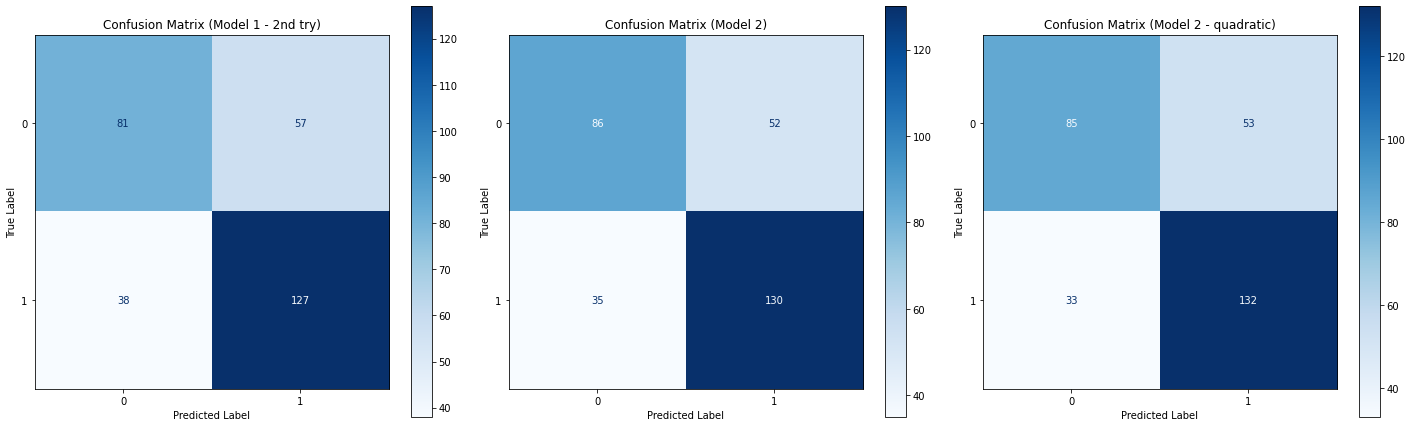

In [30]:
predictions1 = sim1.stan_variable('combined_heart_disease_prob').mean(axis=0)
predictions2 = sim2.stan_variable('combined_heart_disease_prob').mean(axis=0)
predictions2_q = sim2_q.stan_variable('combined_heart_disease_prob').mean(axis=0)

threshold = 0.5
pred_labels1 = (predictions1 > threshold).astype(int)
pred_labels2 = (predictions2 > threshold).astype(int)
pred_labels2_q = (predictions2_q > threshold).astype(int)

cm1 = confusion_matrix(data['target'], pred_labels1)
cm2 = confusion_matrix(data['target'], pred_labels2)
cm2_q = confusion_matrix(data['target'], pred_labels2_q)

# Plot confusion matrices
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Confusion matrix for Model 1
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=[0, 1])
disp1.plot(ax=axs[0], cmap='Blues')
axs[0].set_title('Confusion Matrix (Model 1 - 2nd try)')
axs[0].set_xlabel('Predicted Label')
axs[0].set_ylabel('True Label')

# Confusion matrix for Model 2
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=[0, 1])
disp2.plot(ax=axs[1], cmap='Blues')
axs[1].set_title('Confusion Matrix (Model 2)')
axs[1].set_xlabel('Predicted Label')
axs[1].set_ylabel('True Label')

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2_q, display_labels=[0, 1])
disp2.plot(ax=axs[2], cmap='Blues')
axs[2].set_title('Confusion Matrix (Model 2 - quadratic)')
axs[2].set_xlabel('Predicted Label')
axs[2].set_ylabel('True Label')

plt.tight_layout()
plt.show()

In [31]:
predictions = sim.stan_variable('combined_heart_disease_prob').mean(axis=0)
predictions1 = sim1.stan_variable('combined_heart_disease_prob').mean(axis=0)
predictions2 = sim2.stan_variable('combined_heart_disease_prob').mean(axis=0)
predictions2_q = sim2_q.stan_variable('combined_heart_disease_prob').mean(axis=0)

threshold = 0.5
pred_labels = (predictions > threshold).astype(int)
pred_labels1 = (predictions1 > threshold).astype(int)
pred_labels2 = (predictions2 > threshold).astype(int)
pred_labels2_q = (predictions2_q > threshold).astype(int)

accuracy = accuracy_score(data['target'], pred_labels)
accuracy1 = accuracy_score(data['target'], pred_labels1)
accuracy2 = accuracy_score(data['target'], pred_labels2)
accuracy2_q = accuracy_score(data['target'], pred_labels2_q)

print(f"Accuracy for Model 1: {accuracy:.4f}")
print(f"Accuracy for Model 1 (2nd try): {accuracy1:.4f}")
print(f"Accuracy for Model 2: {accuracy2:.4f}")
print(f"Accuracy for Model 2 (quadratic): {accuracy2_q:.4f}")

Accuracy for Model 1: 0.6139
Accuracy for Model 1 (2nd try): 0.6865
Accuracy for Model 2: 0.7129
Accuracy for Model 2 (quadratic): 0.7162


In [32]:
print(classification_report(data['target'], pred_labels1))
print(classification_report(data['target'], pred_labels2_q))

              precision    recall  f1-score   support

           0       0.68      0.59      0.63       138
           1       0.69      0.77      0.73       165

    accuracy                           0.69       303
   macro avg       0.69      0.68      0.68       303
weighted avg       0.69      0.69      0.68       303

              precision    recall  f1-score   support

           0       0.72      0.62      0.66       138
           1       0.71      0.80      0.75       165

    accuracy                           0.72       303
   macro avg       0.72      0.71      0.71       303
weighted avg       0.72      0.72      0.71       303



In [33]:
info = az.from_cmdstanpy(posterior=sim, log_likelihood='log_lik')
info1 = az.from_cmdstanpy(posterior=sim1, log_likelihood='log_lik')
info2 = az.from_cmdstanpy(posterior=sim2, log_likelihood='log_lik')
info2_q = az.from_cmdstanpy(posterior=sim2_q, log_likelihood='log_lik')
compare_dict = {'model1': info, 'model1 - 2nd try': info1, 'model2': info2, 'model2 - quadratic': info2_q}

In [34]:
waic_compare = az.compare(compare_dict, ic='waic')
waic_compare.head()

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model2 - quadratic,0,-168.908264,5.844891,0.000000,0.981792,7.987751,0.000000,True,log
model2,1,-175.410439,4.158626,6.502175,0.000000,6.603726,3.185133,False,log
model1 - 2nd try,2,-180.207758,2.608881,11.299494,0.000000,6.404009,4.156525,False,log
model1,3,-203.428702,1.056811,34.520438,0.018208,1.916906,7.269090,False,log


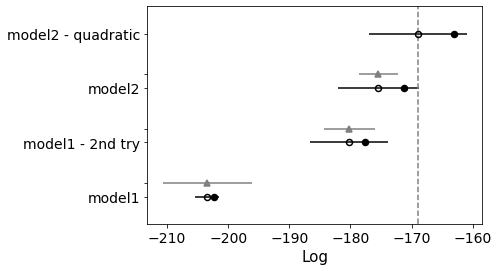

In [35]:
az.plot_compare(waic_compare)
plt.show()

In [37]:
loo_compare = az.compare(compare_dict, ic='loo')
loo_compare.head()

/usr/local/lib/python3.9/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model2 - quadratic,0,-168.917610,5.854238,0.000000,0.980895,7.999309,0.000000,True,log
model2,1,-175.416794,4.164981,6.499184,0.000000,6.604105,3.199872,False,log
model1 - 2nd try,2,-180.207545,2.608669,11.289935,0.000000,6.403969,4.171950,False,log
model1,3,-203.428748,1.056857,34.511137,0.019105,1.916912,7.282709,False,log


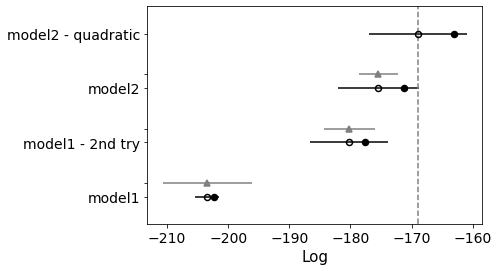

In [38]:
az.plot_compare(loo_compare)
plt.show()

The results given by both methos are similar. The winner in both cases in model no. 2 with five predictors, however the difference is not major. No warning has occurred.